## 使用Pre-trained的CNN

## Part 1：特征提取 Feature Extraction

### 将VGG16的Convolutional Base实例化：

In [9]:
import tensorflow as tf
from keras.applications import VGG16

conv_base = tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False, # 不包含Dense分类器
                  input_shape=(150, 150, 3))

conv_base.summary()

58892288/58889256 [==============================] - 147s 2us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________________

### 方法一：不使用Data Augmentation的快速Feature Extraction

#### 首先，运行ImageDataGenerator实例，将图像及其标签提取为numpy array。我们需要调用conv_base模型的predict方法来从这些图像中提取特征：

In [13]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/dongdongdongdong/Desktop/dogs-vs-cats-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1.0 / 255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # conv_base最后一层输出的形状为(4, 4, 512)
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [16]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


In [15]:
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 2 classes.


In [17]:
test_features, test_labels = extract_features(test_dir, 500)

Found 1000 images belonging to 2 classes.


#### 将features展平

In [18]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (500, 4 * 4 * 512))
test_features = np.reshape(test_features, (500, 4 * 4 * 512))

#### 定义并训练Dense分类器

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_dim=(4 * 4 * 512)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [21]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.5806 - acc: 0.6760 - val_loss: 0.4111 - val_acc: 0.8460
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.4081 - acc: 0.8250 - val_loss: 0.3383 - val_acc: 0.8720
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.3467 - acc: 0.8535 - val_loss: 0.3031 - val_acc: 0.8800
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.3027 - acc: 0.8790 - val_loss: 0.2837 - val_acc: 0.8780
Epoch 5/30
2000/2000 [==============================] - 2s 953us/sample - loss: 0.2790 - acc: 0.8845 - val_loss: 0.2696 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.2542 - acc: 0.8955 - val_loss: 0.2609 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.2501 - acc: 0.9030 - val_loss: 0.2563 - val_acc: 0.8900

#### 绘制结果

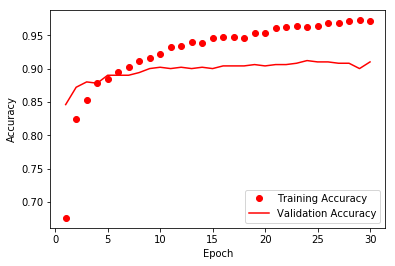

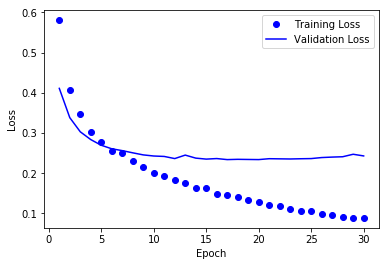

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'ro', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 方法二：使用Data Augmentation的Feature Extraction

#### 扩展conv_base模型，然后在input data上end-to-end地运行（需要GPU）

#### 在Convolutional Base上添加一个Dense分类器：

In [ ]:
from keras import models
from keras import layers

model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

#### 在编译和训练model之前，一定要“freeze” conv_base。“freeze”一个或多个layer指在训练过程中保持其weight不变。如果不这么做，那么conv_base之前学到的表示将会在训练过程中被修改。在Keras中，“freeze”网络的方法是将其trainable属性设为False：

In [ ]:
print('This is the number of trainable weights before freezing the conv base: ', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights before freezing the conv base: ', len(model.trainable_weights))

#### 利用“freeze”的conv_base端到端地训练模型：

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_datagen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
    train_generator,
    step_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)